In [0]:
# Импорт библиотек
import numpy
import pandas as pd

In [0]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [0]:
# Задаем рабочую папку
import os
os.chdir("/content/sample_data")

In [0]:
# Импорт данных
competitions_df = pd.read_csv('Competitions_results_cleaned.csv', sep=',', parse_dates=['date'])

In [0]:
#  Знакомимся с данными
competitions_df.dtypes

In [5]:
#  Знакомимся с данными
competitions_df.head()
#competitions_df.tail()
#competitions_df.shape

,place,last_name,first_name,birth_year,city,team,country,result,disc,points,athlete_group,distance,style,date,pool_city,pool_description,id,pool_size,result_s,gender
0,1,Евмененко,София,2007,Долгопрудный,ДЮСШ,RUS,00:00:33.50,NaN,387.0,Девочки 2007г.р. и моложе,50,баттерфляй,2019-04-22,г.Жлобин,бассейн 50м.,8,50,33.50,Д
1,2,Редюк,Алина,2007,Гомель-1,ГОЦОР ввс,BLR,00:00:35.44,NaN,327.0,Девочки 2007г.р. и моложе,50,баттерфляй,2019-04-22,г.Жлобин,бассейн 50м.,9,50,35.44,Д
2,3,Козловская,Кристина,2007,Минск,Волна,BLR,00:00:36.10,NaN,309.0,Девочки 2007г.р. и моложе,50,баттерфляй,2019-04-22,г.Жлобин,бассейн 50м.,10,50,36.10,Д
3,4,Карпочева,Екатерина,2007,Речица,Олимп,BLR,00:00:36.62,NaN,296.0,Девочки 2007г.р. и моложе,50,баттерфляй,2019-04-22,г.Жлобин,бассейн 50м.,11,50,36.62,Д
4,5,Гисак,Анна,2007,Могилев,СДЮШОР,BLR,00:00:36.96,NaN,288.0,Девочки 2007г.р. и моложе,50,баттерфляй,2019-04-22,г.Жлобин,бассейн 50м.,12,50,36.96,Д


In [129]:
group = 'Девушки 2004-2005 г.р.'
style = 'вольный стиль'
df = competitions_df[competitions_df['athlete_group'] == group][['last_name', 'first_name', 'gender', 'birth_year', 'distance', 'style', 'result_s', 'points']]
df = df[df['style'] == style]

df.head()
# df.shape


,last_name,first_name,gender,birth_year,distance,style,result_s,points
236,Коршак,Елизавета,Д,2005,400,вольный стиль,303.59,472.0
237,Дурнева,Ольга,Д,2004,400,вольный стиль,308.93,448.0
238,Хлистунова,Кристина,Д,2005,400,вольный стиль,314.57,424.0
239,Горовая,Марина,Д,2004,400,вольный стиль,315.60,420.0
240,Катиленец,София,Д,2005,400,вольный стиль,317.30,413.0


In [140]:
# найдем список спортсменов, кто участвовал в нескольких дистанциях
# эквивалент sql-запроса 
# select last_name, first_name from df group by last_name, first_name having count(1) > 1

grouped_dict = df.groupby(['last_name', 'first_name']).groups 
athletes = [key for key, value in grouped_dict.items() if len(value)>1]
athletes

[('Андрусевич', 'Диана'),
 ('Болдырева', 'Инна'),
 ('Горовая', 'Марина'),
 ('Котягова', 'Ксения'),
 ('Наумова', 'Ксения'),
 ('Парванова', 'Дарья'),
 ('Подвязнова', 'Анастасия'),
 ('Хлистунова', 'Кристина')]

In [136]:
# соберем результаты этих спортсменов в одном дата-фрейме

# Вариант 1
df2 = df.groupby(['last_name', 'first_name']).filter(lambda g: len(g) > 1).sort_values(by=['last_name', 'first_name'])
df2.shape

(16, 8)

In [0]:
# Вариант 2
df2 = df[(df['last_name'] == athletes[0][0]) & (df['first_name'] == athletes[0][1])]
for ln, fn in athletes[1:]:
  df2 = pd.concat([df2, df[(df['last_name'] == ln) & (df['first_name'] == fn)]], axis=0) 

df2

In [0]:
# Вариант 3
# 1. Создать датафрейм athletes_df на базе списка атлетов athletes 

athletes_df = pd.DataFrame(athletes, columns=['last_name', 'first_name']) 

# 2. Выполнить операцию внутреннего соединения df и athletes_df

df2 = pd.merge(df, athletes_df, on=['last_name', 'first_name'], how='inner')


# недостаток этого метада - несогласованный порядок записей в двух датафреймах,
# для построения графиков нужно сортировать датафреймы 
# в нашем случае один датафрейм (athlete_df) уже отсортирован)

df2 = df2.sort_values(by=['last_name', 'first_name'])
df2

**На какой дистанции спортсмены показали себя лучше? Кто из них лучший спринтер, а кто лучший стайер?**

Попробуем определить ответы на эти вопросы, построив 2 графика

**1. Дистанция/Время**

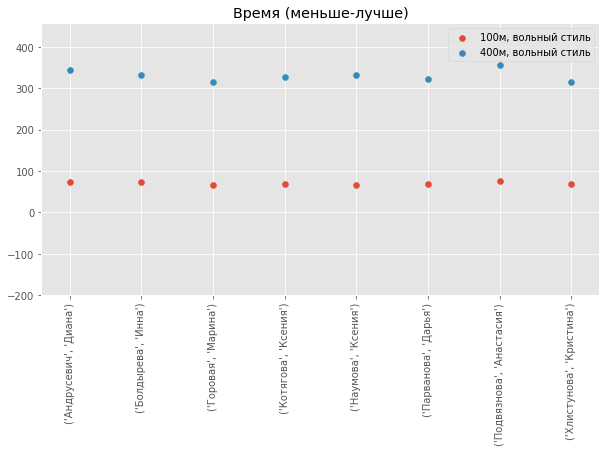

In [141]:
X = [str(athletes) for athletes in athletes]
Y1 = df2[df2['distance'] == 100]['result_s'] 
Y2 = df2[df2['distance'] == 400]['result_s'] 

plt.figure(figsize=(10,5))
plt.scatter(X, Y1, label='100м, вольный стиль')
plt.scatter(X, Y2, label='400м, вольный стиль')

# plt.hlines(y=Y1.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='red')
# plt.hlines(y=Y2.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='blue')

plt.ylim(-200, max(Y2)+100)
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title('Время (меньше-лучше)')

plt.show()

График невыразительный

**2. Дистанция/Очки**

**Использование производной метрики ("фичи") points позволяет лучше видеть данные:**

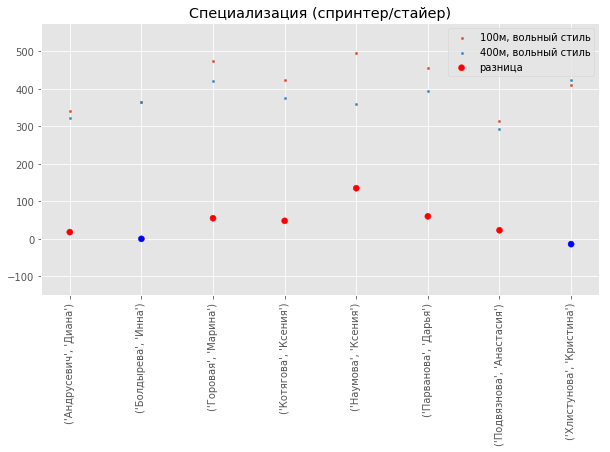

In [142]:
X = [str(athletes) for athletes in athletes]
Y1 = df2[df2['distance'] == 100]['points'] 
Y2 = df2[df2['distance'] == 400]['points'] 
Y3 = numpy.array([Y1.iloc[i] - Y2.iloc[i] for i in range(len(Y1))])

colors = numpy.where(Y3 > 10, 'red', 'blue')
plt.figure(figsize=(10,5))
plt.scatter(X, Y1, s=5, label='100м, вольный стиль')
plt.scatter(X, Y2, s=5, label='400м, вольный стиль')
plt.scatter(X, Y3, color=colors, label='разница')

# plt.hlines(y=Y1.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='red')
# plt.hlines(y=Y2.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='blue')

plt.ylim(-150, max(Y2)+150)
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title('Специализация (спринтер/стайер)')

plt.show()

Выглядит неплохо.

**Тот же график для юношей:**

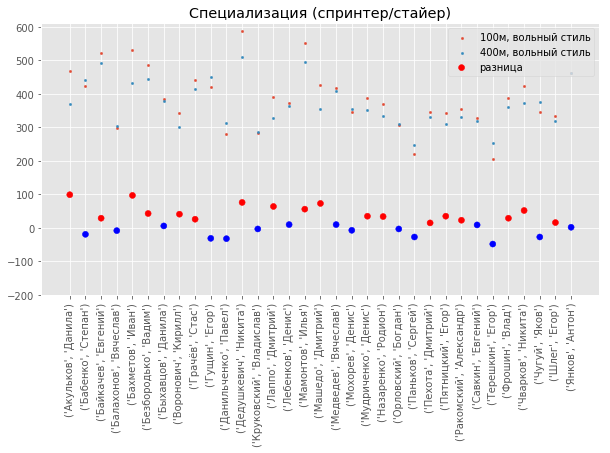

In [143]:
group = 'Юноши 2004-2005 г.р.'
style = 'вольный стиль'

df = competitions_df[competitions_df['athlete_group'] == group][['last_name', 'first_name', 'gender', 'birth_year', 'distance', 'style', 'result_s', 'points']]
df = df[df['style'] == style]

# Плохие для группировки строки: df[(df['first_name'].isnull()) | (df['last_name'].isnull())]
df = df.dropna(axis='index', how='any', subset=['first_name'])

grouped_dict = df.groupby(['last_name', 'first_name']).groups 
athletes = [key for key, value in grouped_dict.items() if len(value)>1]

df2 = df.groupby(['last_name', 'first_name']).filter(lambda g: len(g)>1).sort_values(by=['last_name', 'first_name'])

X = [str(athletes) for athletes in athletes]

Y1 = df2[df2['distance'] == 100]['points'] 
Y2 = df2[df2['distance'] == 400]['points'] 
Y3 = numpy.array([Y1.iloc[i] - Y2.iloc[i] for i in range(len(Y1))])

colors = numpy.where(Y3 > 10, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(X, Y1, s=5, label='100м, вольный стиль')
plt.scatter(X, Y2, s=5, label='400м, вольный стиль')
plt.scatter(X, Y3, color=colors, label='разница')

# plt.hlines(y=Y1.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='red')
# plt.hlines(y=Y2.mean(), xmin=X[0], xmax=X[-1], linestyle='--', color='blue')

plt.ylim(-200, max(Y2)+100)
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.title('Специализация (спринтер/стайер)')

plt.show()

Модель для определения склонности пловца к коротким или длинным дистанциям (спринтер/стайер) найдена:

**if** (очки_короткая_дист - очки_длинная_дист > 10):

   спринтер  # red
    
**else**

   стайер  # blue

**После некоторого знакомства с данными, попробуем решить более сложную задачу**

Если известно что спортсмены могут плыть только одну дистанцию из двух и только 10 спортсменов может участвовать в каждой из них, отнести каждого спортсмена к одному из трех классов (плыть короткую, плыть длинную, не плыть ничего) так, чтобы максимизировать предполагаемое суммарное число полученных очков


In [0]:
#  Вопрос - как разбить данные на тренировочную и тестовые группы??

